In [ ]:
import pandas as pd
import talib
import json

# Substitua 'caminho_do_arquivo.csv' pelo caminho do seu arquivo CSV
caminho_do_arquivo = "C:/Projetos/SP500mM5.csv"

# Configurações do mercado futuro
contract_size = 1  # Tamanho do contrato
tick_value = 0.1    # Valor de cada ponto

# Lê o arquivo CSV
df = pd.read_csv(caminho_do_arquivo)

# Converte a coluna de data para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filtra os anos de 2015 a 2025
df_filtered = df[(df['Date'].dt.year >= 2023) & (df['Date'].dt.year <= 2026)]

# Calcula indicadores
df_filtered['ADX'] = talib.ADX(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['DI+'] = talib.PLUS_DI(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['DI-'] = talib.MINUS_DI(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=14)
df_filtered['TR'] = talib.ATR(df_filtered['High'], df_filtered['Low'], df_filtered['Close'], timeperiod=10)
df_filtered['Operation'] = df_filtered.apply(lambda row: 'Compra' if row['DI+'] > row['DI-'] else 'Venda', axis=1)

# Inicializa variáveis
operations = []
current_operation = None
operation_open = False

# Itera sobre as linhas do DataFrame
for i in range(len(df_filtered)):
    row = df_filtered.iloc[i]
    
    # Se não há operação aberta, verifica se pode abrir uma nova
    if not operation_open and row['ADX'] > 32:
        # Calcula Stop e Gain
        if row['Operation'] == 'Compra':
            stop = row['Close'] - 1.5 * row['TR']
            gain = row['Close'] + 4 * row['TR']
        else:
            stop = row['Close'] + 1.5 * row['TR']
            gain = row['Close'] - 4 * row['TR']
        
        # Abre nova operação
        current_operation = {
            "EntryDate": row['Date'].strftime('%Y-%m-%d'),
            "Type": row['Operation'],
            "EntryPrice": row['Close'],
            "Stop": stop,
            "Gain": gain,
            "ExitDate": None,
            "ExitPrice": None,
            "Result": None,
            "Profit/Loss": None
        }
        operation_open = True
        continue

    # Se há operação aberta, verifica se atingiu Stop ou Gain
    if operation_open and current_operation:
        if current_operation['Type'] == 'Compra':
            if row['Low'] <= current_operation['Stop']:
                current_operation['Result'] = 'Stop'
                current_operation['ExitPrice'] = current_operation['Stop']
                current_operation['Profit/Loss'] = -abs((current_operation['Stop'] - current_operation['EntryPrice']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
            elif row['High'] >= current_operation['Gain']:
                current_operation['Result'] = 'Gain'
                current_operation['ExitPrice'] = current_operation['Gain']
                current_operation['Profit/Loss'] = abs((current_operation['Gain'] - current_operation['EntryPrice']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
        else:  # Venda
            if row['High'] >= current_operation['Stop']:
                current_operation['Result'] = 'Stop'
                current_operation['ExitPrice'] = current_operation['Stop']
                current_operation['Profit/Loss'] = -abs((current_operation['EntryPrice'] - current_operation['Stop']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d')
                operations.append(current_operation)
                operation_open = False
                current_operation = None
            elif row['Low'] <= current_operation['Gain']:
                current_operation['Result'] = 'Gain'
                current_operation['ExitPrice'] = current_operation['Gain']
                current_operation['Profit/Loss'] = abs((current_operation['EntryPrice'] - current_operation['Gain']) * contract_size * tick_value)
                current_operation['ExitDate'] = row['Date'].strftime('%Y-%m-%d')
                operations.append(current_operation)
                operation_open = False
                current_operation = None

# Salva os resultados em JSON
with open("operacoes.json", "w") as json_file:
    json.dump(operations, json_file, indent=4)

# Imprime estatísticas
print(f"Total de operações: {len(operations)}")
print(f"Gains: {sum(1 for op in operations if op['Result'] == 'Gain')}")
print(f"Stops: {sum(1 for op in operations if op['Result'] == 'Stop')}")
print(f"Resultado total: {sum(op['Profit/Loss'] for op in operations):.2f}")

Total de operações: 2067
Gains: 598
Stops: 1469
Resultado total: 70.39


In [3]:
# Contar a quantidade de operações com "Gain" e "Stop"
gain_count = sum(1 for op in operations if op['Result'] == 'Gain')
loss_count = sum(1 for op in operations if op['Result'] == 'Stop')

# Calcular o lucro ou prejuízo total
total_profit_loss = sum(op['Profit/Loss'] for op in operations)

# Calcular a média de ganhos e perdas
average_gain = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Gain') / gain_count if gain_count > 0 else 0
average_loss = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Stop') / loss_count if loss_count > 0 else 0

# Calcular soma total dos gains e losses
total_gains = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Gain')
total_losses = sum(op['Profit/Loss'] for op in operations if op['Result'] == 'Stop')

# Calcular razão gain/loss
gain_loss_ratio = abs(total_gains / total_losses) if total_losses != 0 else 0

# Criar um dicionário com os resultados
summary = {
    "Total Gains": gain_count,
    "Total Losses": loss_count,
    "Net Profit/Loss": total_profit_loss,
    "Average Gain": average_gain,
    "Average Loss": average_loss,
    "Total Gains Value": total_gains,
    "Total Losses Value": total_losses,
    "Gain/Loss Ratio": gain_loss_ratio
}

# Salvar o resumo em um arquivo JSON
with open("summaryFull.json", "w") as summary_file:
    json.dump(summary, summary_file, indent=4)

# Exibir o resumo no terminal
print(summary)

NameError: name 'operations' is not defined

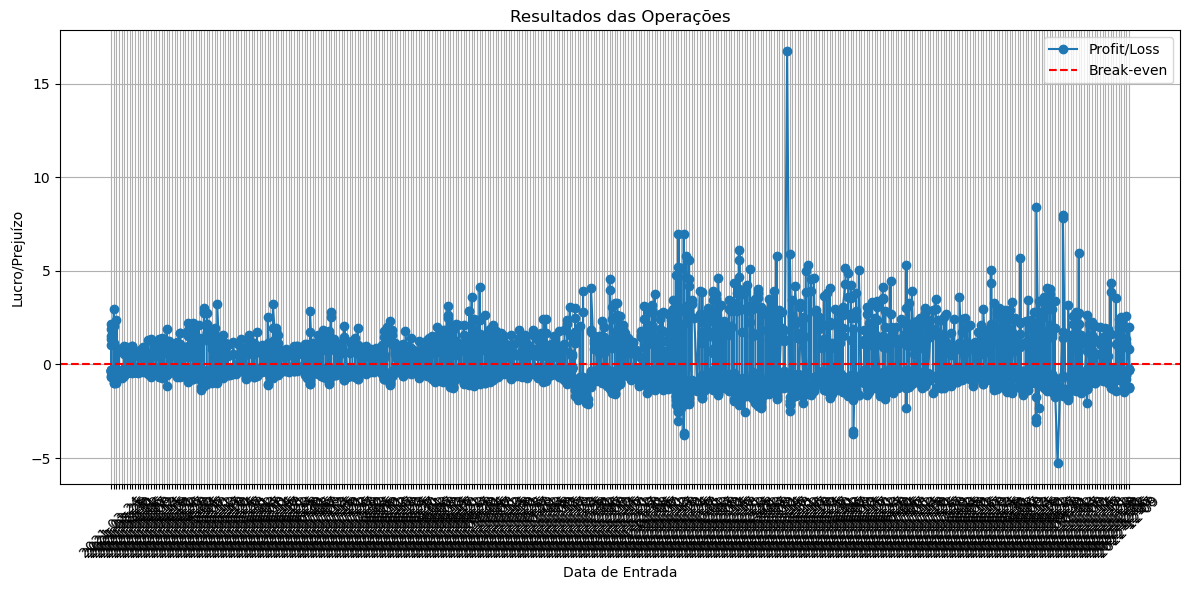

In [ ]:
import json

import matplotlib.pyplot as plt

# Ler o arquivo operacoes.json
with open("operacoes.json", "r") as file:
    operations = json.load(file)

# Extrair dados para o gráfico
entry_dates = [op['EntryDate'] for op in operations]
profit_loss = [op['Profit/Loss'] for op in operations]

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(entry_dates, profit_loss, marker='o', label='Profit/Loss')
plt.axhline(0, color='red', linestyle='--', label='Break-even')

# Configurar o gráfico
plt.title('Resultados das Operações')
plt.xlabel('Data de Entrada')
plt.ylabel('Lucro/Prejuízo')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Exibir o gráfico
plt.tight_layout()
plt.show()